In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from PIL import Image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import os
import cv2

import numpy as np

Using TensorFlow backend.


In [2]:
model_path = 'output'

In [3]:
model = load_model(model_path+'/image_classification_2020-02-10.model')

In [4]:
#get name of final convolutional block
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
import cv2
img_path = '/home/slalom/Desktop/image-classification/dataset/evaluation/ready/'
size = (224,224)

for file in os.listdir(path = img_path):
    #print(os.path.join(img_path,file))
    
    try:
        im = image.load_img(img_path+file, target_size=(224, 224))
        #img = Image.open(os.path.join(img_path,file))
        #img = img.resize(size)
        print(im)

        x = image.img_to_array(im) # convert to array
        x = np.expand_dims(x, axis=0) #transforms array to batch size (1, 224, 224, 3) 
        x = preprocess_input(x) #channel-wise color normalization

        preds = model.predict(x)

        #get predicted class index
        class_idx = np.argmax(preds[0])
        #get class label in the predicton vector
        class_output=model.output[:,class_idx]

        #last convolutional layer, from model summary above
        last_conv_layer = model.get_layer('block5_conv3')

        print(last_conv_layer)

        # This is the gradient of the class label we predicted for the specified image, with regard to
        # the output feature map of `block5_conv3`
        grads = K.gradients(class_output, last_conv_layer.output)[0]

        print(grads)

        # This is a vector, where each entry
        # is the mean intensity of the gradient over a specific feature map channel
        pooled_grads = K.mean(grads, axis=(0, 1, 2)) # vector shape (512,)

        # This function allows us to access the values of the quantities just defined:
        # `pooled_grads` and the output feature map of `block5_conv3`,
        # given a sample image
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

        # These are the values of these two quantities, as Numpy arrays,
        # given our image
        pooled_grads_value, conv_layer_output_value = iterate([x])

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the predicted class
        for i in range(int(pooled_grads.shape[0])):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        # The channel-wise mean of the resulting feature map
        # is our heatmap of class activation
        heatmap = np.mean(conv_layer_output_value, axis=-1)

        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        # load the original image
        output = cv2.imread(img_path+file)

        # Resize the heatmap to have the same size as the original image
        heatmap = cv2.resize(heatmap, (output.shape[1], output.shape[0]))

        # We convert the heatmap to RGB
        heatmap = np.uint8(255 * heatmap)

        # We apply the heatmap to the original image
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # 0.4 here is a heatmap intensity factor
        superimposed_img = heatmap * 0.4 + output

        cv2.imwrite('class_activation/evaluation/ready/'+file, superimposed_img)    
    except Exception as e:
        print(e)
        print('passing..')
        pass

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1B0CC6F110>
Tensor("gradients_1/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1AE028C6D0>
Tensor("gradients_2/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1AE0489FD0>
Tensor("gradients_3/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1AE03387D0>
Tensor("gradients_4/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1AC05A3690>
Tensor("gradients_5/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1AC05A38D0>
Tensor("gradients_6/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A6B8B73D0>
Tensor("gradients_37/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1AA80C7150>
Tensor("gradients_38/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A78059850>
Tensor("gradients_39/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A6B2F64D0>
Tensor("gradients_40/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A6ACD60D0>
Tensor("gradients_41/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A6ACC3F50>
Tensor("gradients_42/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=f

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A69B13B50>
Tensor("gradients_73/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A4B1D06D0>
Tensor("gradients_74/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A68840E90>
Tensor("gradients_75/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A4BAAC6D0>
Tensor("gradients_76/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A4B055450>
Tensor("gradients_77/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A4AD1DBD0>
Tensor("gradients_78/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=f

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A467B3190>
Tensor("gradients_109/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A48914A10>
Tensor("gradients_110/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A48914550>
Tensor("gradients_111/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A467B3190>
Tensor("gradients_112/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A4768E290>
Tensor("gradients_113/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A42DEFA90>
Tensor("gradients_114/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), d

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A4106F1D0>
Tensor("gradients_145/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A40C698D0>
Tensor("gradients_146/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A405E1810>
Tensor("gradients_147/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A400721D0>
Tensor("gradients_148/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A40090810>
Tensor("gradients_149/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A3C4D4850>
Tensor("gradients_150/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), d

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A3A3E7A50>
Tensor("gradients_181/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A39F149D0>
Tensor("gradients_182/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A39A7D310>
Tensor("gradients_183/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A36140A90>
Tensor("gradients_184/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A36140FD0>
Tensor("gradients_185/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1A390754D0>
Tensor("gradients_186/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), d

In [6]:
#imgage path
img_path = 'dataset/training/ready/'
#type in image name
img_name = '20191204-140330-161031.jpg'

In [8]:
img = image.load_img(img_path+img_name, target_size=(224, 224))
print(img)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2098D71950>


In [8]:
x = image.img_to_array(img) # convert to array
x = np.expand_dims(x, axis=0) #transforms array to batch size (1, 224, 224, 3) 
x = preprocess_input(x) #channel-wise color normalization

In [9]:
preds = model.predict(x)

In [10]:
print(f'Predicted: {preds}')

Predicted: [[0.10226447 0.0016752  0.89606035]]


In [11]:
#get predicted class index
class_idx = np.argmax(preds[0])
#get class label in the predicton vector
class_output=model.output[:,class_idx]

In [12]:
#last convolutional layer, from model summary above
last_conv_layer = model.get_layer('block5_conv3')

In [13]:
# This is the gradient of the class label we predicted for the specified image, with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(class_output, last_conv_layer.output)[0]

# This is a vector, where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2)) # vector shape (512,)

# This function allows us to access the values of the quantities just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our image
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the predicted class
for i in range(int(pooled_grads.shape[0])):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

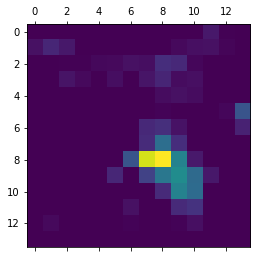

In [14]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [15]:
import cv2

# load the original image
img = cv2.imread(img_path+img_name)

# Resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

In [16]:
# Save the image to disk
cv2.imwrite('class_activation/'+img_name, superimposed_img)

True